/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5628 - loss: 0.6823
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5071 - loss: 0.6944
Clean data - Test accuracy: 0.5500
Noisy data - Test accuracy: 0.5200


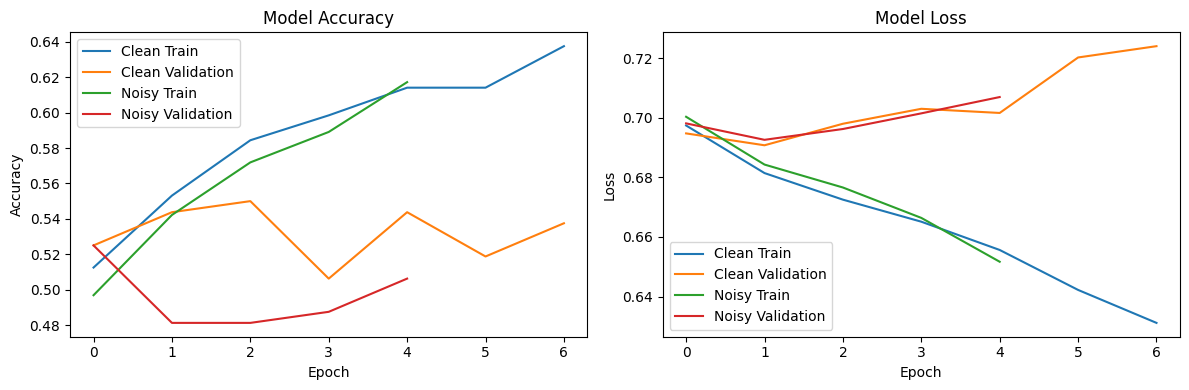

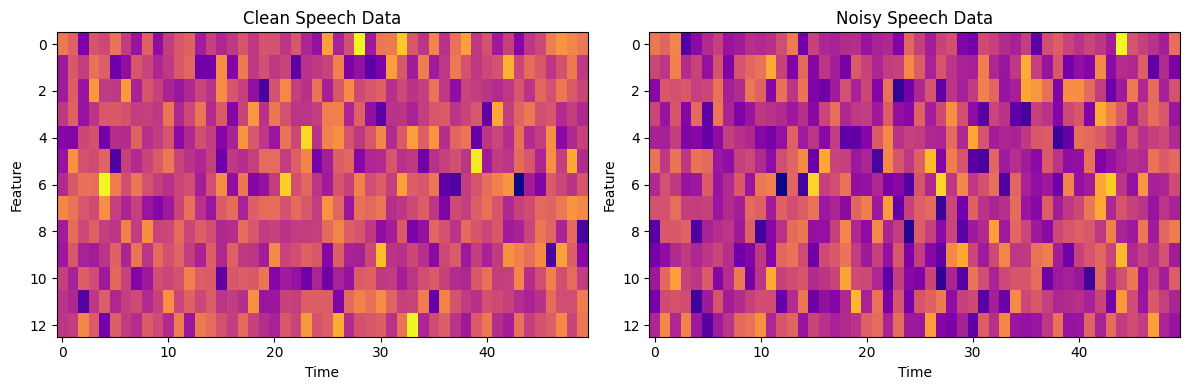

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def generate_synthetic_speech_data(num_samples, sequence_length, num_features, noise_level=0.0):
    X = np.random.randn(num_samples, sequence_length, num_features)
    y = np.random.randint(0, 2, size=(num_samples, 1))
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, X.shape)
        X += noise
    return X, y

# Parameters
num_samples = 1000
sequence_length = 50
num_features = 13

# Generate synthetic data
X_clean, y = generate_synthetic_speech_data(num_samples, sequence_length, num_features)
X_noisy, _ = generate_synthetic_speech_data(num_samples, sequence_length, num_features, noise_level=0.5)

# Split data into training and testing sets
train_size = int(0.8 * num_samples)
X_train_clean, X_test_clean = X_clean[:train_size], X_clean[train_size:]
X_train_noisy, X_test_noisy = X_noisy[:train_size], X_noisy[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create GRU model
def create_model():
    model = Sequential([
        GRU(64, input_shape=(sequence_length, num_features), return_sequences=True),
        GRU(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models
model_clean = create_model()
history_clean = model_clean.fit(
    X_train_clean, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

model_noisy = create_model()
history_noisy = model_noisy.fit(
    X_train_noisy, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# Evaluate models
test_loss_clean, test_accuracy_clean = model_clean.evaluate(X_test_clean, y_test)
test_loss_noisy, test_accuracy_noisy = model_noisy.evaluate(X_test_noisy, y_test)

# Print accuracy
print(f"Clean data - Test accuracy: {test_accuracy_clean:.4f}")
print(f"Noisy data - Test accuracy: {test_accuracy_noisy:.4f}")

# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_clean.history['accuracy'], label='Clean Train')
plt.plot(history_clean.history['val_accuracy'], label='Clean Validation')
plt.plot(history_noisy.history['accuracy'], label='Noisy Train')
plt.plot(history_noisy.history['val_accuracy'], label='Noisy Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_clean.history['loss'], label='Clean Train')
plt.plot(history_clean.history['val_loss'], label='Clean Validation')
plt.plot(history_noisy.history['loss'], label='Noisy Train')
plt.plot(history_noisy.history['val_loss'], label='Noisy Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize sample data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_clean[0].T, aspect='auto', cmap='plasma')
plt.title('Clean Speech Data')
plt.xlabel('Time')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
plt.imshow(X_noisy[0].T, aspect='auto', cmap='plasma')
plt.title('Noisy Speech Data')
plt.xlabel('Time')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()
